In [ ]:
import pandas as pd

# Make sure the file 'vitalsign.csv' is in the same directory
# as your script, or provide the full path to it.
file_path = '/content/MIMIC 4/vitalsign.csv'

try:
    # Load the dataset
    vitalsign_df = pd.read_csv(file_path)

    # Print the summary info
    print("--- Data Structure and Info ---")
    vitalsign_df.info()

    # Print the first 5 rows
    print("\n--- First 5 Rows of Data ---")
    print(vitalsign_df.head())

except FileNotFoundError:
    print(f"Error: The file was not found at '{file_path}'. Please make sure the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Data Structure and Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject_id   1038 non-null   int64  
 1   stay_id      1038 non-null   int64  
 2   charttime    1038 non-null   object 
 3   temperature  579 non-null    float64
 4   heartrate    1008 non-null   float64
 5   resprate     990 non-null    float64
 6   o2sat        971 non-null    float64
 7   sbp          998 non-null    float64
 8   dbp          998 non-null    float64
 9   rhythm       33 non-null     object 
 10  pain         736 non-null    object 
dtypes: float64(6), int64(2), object(3)
memory usage: 89.3+ KB

--- First 5 Rows of Data ---
   subject_id   stay_id            charttime  temperature  heartrate  \
0    10014729  37887480  2125-03-19 13:22:00          NaN      124.0   
1    10014729  37887480  2125-03-19 18:28:00         98.9      106.0   
2    1

## Initial Observations
Missing Data: There are a lot of missing values, especially in temperature and rhythm. For example, temperature is missing in almost half the rows. We will need to decide how to handle these missing values (this is called "imputation").

Data Types: The charttime is currently an object (text). We will need to convert this into a proper datetime format so we can perform time-based analysis. The pain column is also an object and will likely need to be converted to a numerical format.

Irregular Measurements: Looking at the first few rows for the same stay_id, the timestamps are not perfectly regular (13:07, 13:22, 13:24, 16:23). This is normal for real-world clinical data.

In [ ]:
import numpy as np

# --- 2. Convert 'charttime' to Datetime ---
vitalsign_df['charttime'] = pd.to_datetime(vitalsign_df['charttime'])

# --- 3. Convert 'pain' Column to Numeric ---
vitalsign_df['pain'] = pd.to_numeric(vitalsign_df['pain'], errors='coerce')

# --- 4. Drop the 'rhythm' Column ---
vitalsign_df = vitalsign_df.drop(columns=['rhythm'])

# --- 5. Sort Data Chronologically for Each Patient Stay ---
vitalsign_df = vitalsign_df.sort_values(by=['stay_id', 'charttime'])

# --- 6. Impute Missing Vital Signs using Forward Fill ---
vitals_columns = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']
vitalsign_df[vitals_columns] = vitalsign_df.groupby('stay_id')[vitals_columns].transform(lambda x: x.ffill())

# --- 7. (Optional) Show Cleaned Data Info ---
print("--- Cleaned Data Info ---")
vitalsign_df.info()
print("\n--- First 10 Rows of Cleaned Data ---")
print(vitalsign_df.head(10))

--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 328 to 668
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   subject_id   1038 non-null   int64         
 1   stay_id      1038 non-null   int64         
 2   charttime    1038 non-null   datetime64[ns]
 3   temperature  905 non-null    float64       
 4   heartrate    1027 non-null   float64       
 5   resprate     1026 non-null   float64       
 6   o2sat        1016 non-null   float64       
 7   sbp          1028 non-null   float64       
 8   dbp          1028 non-null   float64       
 9   pain         897 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 89.2 KB

--- First 10 Rows of Cleaned Data ---
      subject_id   stay_id           charttime  temperature  heartrate  \
328     10014354  30094124 2147-11-14 18:23:00         97.3       80.0   
327     10014354  30094124

## Create rolling window feature

Our plan is to calculate statistics for each vital sign over a rolling 1-hour window. For every measurement, we'll look back at the previous 60 minutes of data for that patient and calculate the mean, standard deviation, min, and max.



In [ ]:


# This assumes 'vitalsign_df' is your cleaned DataFrame.
# Make sure it's sorted by stay_id and charttime.
vitalsign_df = vitalsign_df.sort_values(by=['stay_id', 'charttime'])

# --- 1. Set 'charttime' as the index BEFORE grouping ---
df_indexed = vitalsign_df.set_index('charttime')

# --- 2. Define Vitals and Window Size ---
vitals_to_feature = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']
window_size = '60min'

# --- 3. Calculate All Rolling Features Efficiently ---
rolling_features = df_indexed.groupby('stay_id')[vitals_to_feature].rolling(window=window_size).agg(['mean', 'std', 'min', 'max'])

# --- 4. Clean Up Column Names ---
rolling_features.columns = ['_'.join(col).strip() for col in rolling_features.columns.values]
rolling_features = rolling_features.add_suffix(f'_{window_size}')

# --- 5. CORRECTED MERGE ---
# We no longer use the 'on=' parameter. Instead, we merge the original DataFrame
# with the new features based on their shared index (stay_id and charttime).
vitalsign_df_with_features = vitalsign_df.merge(
    rolling_features,
    left_on=['stay_id', 'charttime'],
    right_index=True,
    how='left'
)

# --- 6. Show the Results ---
print("--- Data Info After Adding Features ---")
vitalsign_df_with_features.info()

print("\n--- First 10 Rows with New Rolling Features ---")
print(vitalsign_df_with_features.head(10))

--- Data Info After Adding Features ---
<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 328 to 668
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              1038 non-null   int64         
 1   stay_id                 1038 non-null   int64         
 2   charttime               1038 non-null   datetime64[ns]
 3   temperature             905 non-null    float64       
 4   heartrate               1027 non-null   float64       
 5   resprate                1026 non-null   float64       
 6   o2sat                   1016 non-null   float64       
 7   sbp                     1028 non-null   float64       
 8   dbp                     1028 non-null   float64       
 9   pain                    897 non-null    float64       
 10  temperature_mean_60min  905 non-null    float64       
 11  temperature_std_60min   272 non-null    float64       
 12  temperature_

# Part 1: Identifying Alarm Events
First, let's create a new column in our vitalsign_df that flags each row as an "alarm" or "no alarm." We'll start with some standard clinical thresholds. For this example, we'll define an alarm as a moment when:

Heart rate is dangerously high (> 140 bpm)

Or, oxygen saturation is dangerously low (< 85%)


In [34]:
# --- Define Alarm Thresholds ---
HIGH_HR_THRESHOLD = 140
LOW_SPO2_THRESHOLD = 85

# --- Create the 'alarm_flag' column ---
# The flag is 1 if an alarm condition is met, otherwise it's 0.
vitalsign_df['alarm_flag'] = np.where(
    (vitalsign_df['heartrate'] > HIGH_HR_THRESHOLD) |
    (vitalsign_df['o2sat'] < LOW_SPO2_THRESHOLD),
    1,
    0
)

# --- Show the results ---
# Let's see how many alarm events we've identified.
alarm_count = vitalsign_df['alarm_flag'].sum()
print(f"Based on our thresholds, we have identified {alarm_count} time points as potential alarm events.")

# Display the rows where an alarm was flagged
print("\nHere are some examples of rows flagged as an alarm:")
print(vitalsign_df[vitalsign_df['alarm_flag'] == 1].head())

Based on our thresholds, we have identified 8 time points as potential alarm events.

Here are some examples of rows flagged as an alarm:
     subject_id   stay_id           charttime  temperature  heartrate  \
827    10038999  30272878 2131-05-22 20:51:00          NaN      141.0   
8      10026255  34236274 2201-07-07 13:52:00         98.1      150.0   
6      10026255  34236274 2201-07-07 16:14:00         99.0      142.0   
786    10023117  35716124 2175-07-06 15:15:00         96.8      106.0   
794    10023117  35716124 2175-07-06 15:30:00         96.8      106.0   

     resprate  o2sat    sbp    dbp  pain  alarm_flag  
827      13.0  100.0  159.0   96.0   NaN           1  
8        18.0   93.0  133.0  101.0   8.0           1  
6        26.0   92.0  132.0   88.0   7.0           1  
786      18.0   10.0   86.0   52.0   0.0           1  
794      18.0   10.0   83.0   52.0   0.0           1  


## The Challenge and a New Method
The challenge is that without the inputevents.csv and procedureevents.csv files, we can't label an alarm as "True" just because a nurse intervened. We proceed with the unsupervised anomaly detection method what is this

In [35]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# This assumes 'vitalsign_df_with_features' is your DataFrame from the previous step.
# For this example, let's create a placeholder if you don't have it loaded.
# vitalsign_df_with_features = pd.read_csv('your_features_file.csv') # In a real scenario

# --- 1. Select the Features for the Model ---
# We'll use the raw vitals and all the rolling features we created.
features = [
    'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
    'temperature_mean_60min', 'temperature_std_60min', 'temperature_min_60min', 'temperature_max_60min',
    'heartrate_mean_60min', 'heartrate_std_60min', 'heartrate_min_60min', 'heartrate_max_60min',
    'resprate_mean_60min', 'resprate_std_60min', 'resprate_min_60min', 'resprate_max_60min',
    'o2sat_mean_60min', 'o2sat_std_60min', 'o2sat_min_60min', 'o2sat_max_60min',
    'sbp_mean_60min', 'sbp_std_60min', 'sbp_min_60min', 'sbp_max_60min',
    'dbp_mean_60min', 'dbp_std_60min', 'dbp_min_60min', 'dbp_max_60min',
    'pain_mean_60min', 'pain_std_60min', 'pain_min_60min', 'pain_max_60min'
]

# Create a new DataFrame with only the features we need
model_df = vitalsign_df_with_features[features].copy()


# --- 2. Handle Missing Values ---
# The rolling features will have NaN at the start of each patient's stay.
# The model can't handle missing values, so we'll drop these rows for now.
model_df.dropna(inplace=True)


# --- 3. Scale the Data ---
# Anomaly detection works best when all features are on a similar scale.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(model_df)


# --- 4. Train the Isolation Forest Model ---
# 'contamination' is an estimate of the proportion of outliers in the data.
# We can start with a small number like 0.05 (5%).
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(scaled_features)


# --- 5. Get Anomaly Scores ---
# The decision_function gives scores where lower is more anomalous.
# We'll invert the scores so that a higher number means a higher anomaly score.
anomaly_scores = -1 * iso_forest.decision_function(scaled_features)


# --- 6. Add Scores Back to the DataFrame ---
# First, get the original index from the cleaned model_df
original_indices = model_df.index

# Add the scores to your main DataFrame
vitalsign_df_with_features['anomaly_score'] = np.nan # Create column with NaNs
vitalsign_df_with_features.loc[original_indices, 'anomaly_score'] = anomaly_scores


# --- 7. Show the Results ---
print("--- DataFrame with Anomaly Scores ---")
print(vitalsign_df_with_features[['stay_id', 'charttime', 'heartrate', 'o2sat', 'anomaly_score']].head(10))

print("\n--- Top 10 Most Anomalous Events ---")
# Let's look at the rows with the highest anomaly scores
print(vitalsign_df_with_features.sort_values(by='anomaly_score', ascending=False).head(10))

--- DataFrame with Anomaly Scores ---
       stay_id           charttime  heartrate  o2sat  anomaly_score
328   30094124 2147-11-14 18:23:00       80.0   99.0            NaN
327   30094124 2147-11-14 22:08:00       82.0  100.0            NaN
1003  30115213 2147-12-30 08:40:00       83.0  100.0            NaN
1004  30115213 2147-12-30 08:48:00       89.0  100.0            NaN
948   30193781 2198-04-17 11:42:00       88.0  100.0            NaN
950   30193781 2198-04-17 15:09:00      105.0   97.0            NaN
947   30193781 2198-04-17 17:20:00      109.0   96.0            NaN
946   30193781 2198-04-17 18:24:00      120.0   97.0            NaN
949   30193781 2198-04-17 19:48:00      122.0   98.0            NaN
154   30225689 2149-09-20 05:50:00       72.0  100.0            NaN

--- Top 10 Most Anomalous Events ---
      subject_id   stay_id           charttime  temperature  heartrate  \
962     10002930  31579293 2196-04-14 11:12:00         36.1       78.0   
462     10039708  30915333 2

## Visualizing Anomalies for a Single Patient
The code below will automatically find the patient (stay_id) who had the single most anomalous event and create a plot for them.

Plotting results for stay_id: 31579293, which had the highest anomaly score.


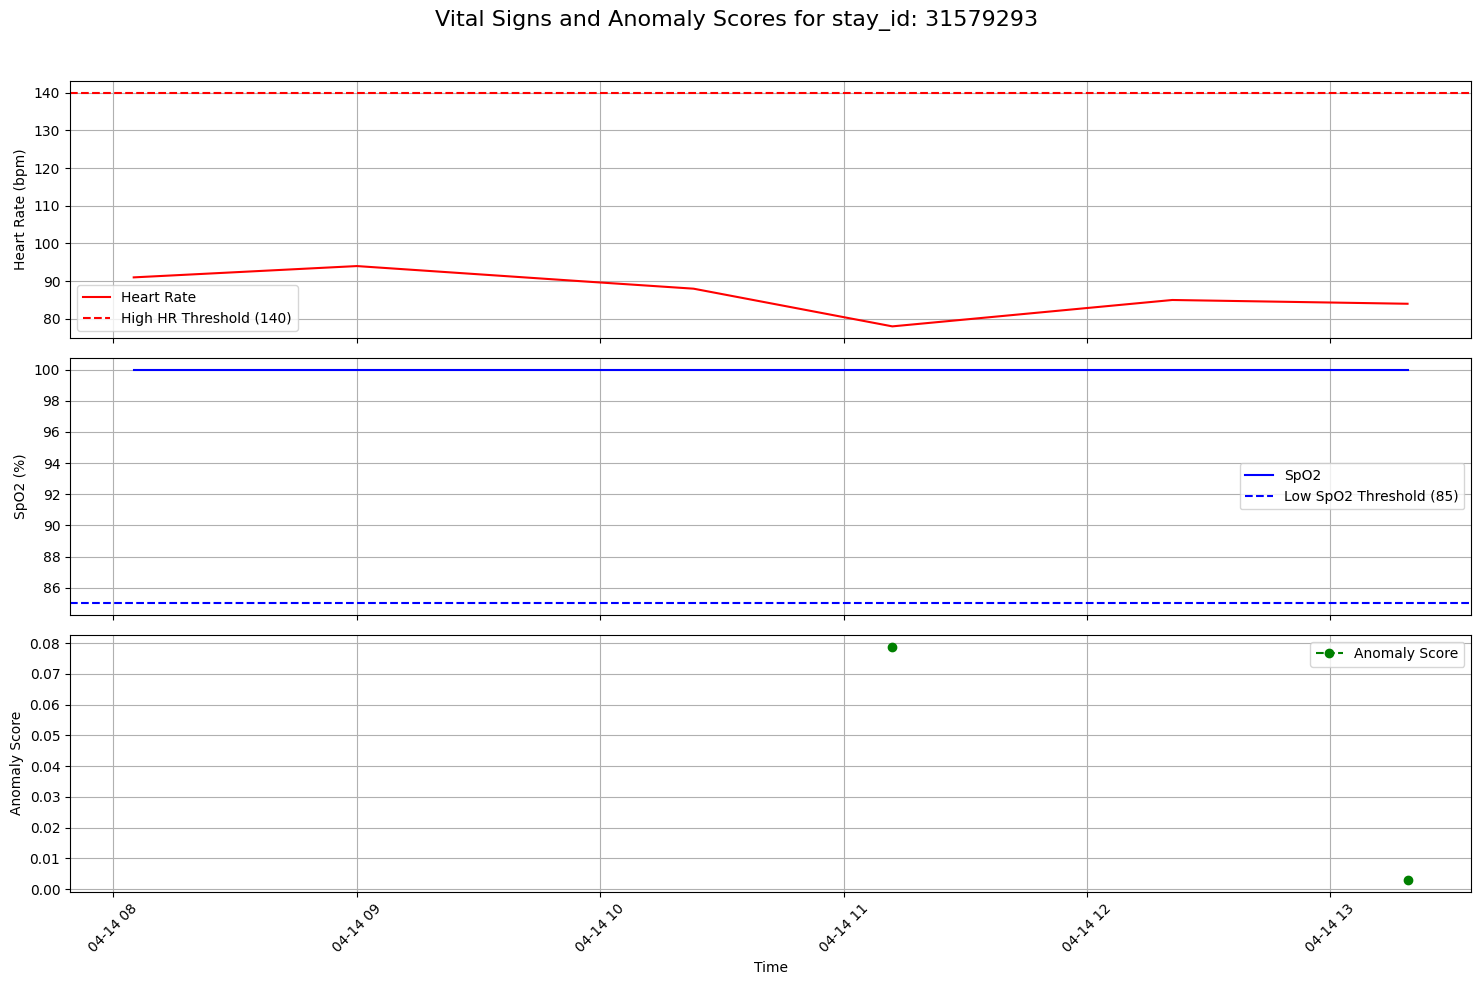

In [36]:
import matplotlib.pyplot as plt

# This assumes 'vitalsign_df_with_features' is your DataFrame with the anomaly scores.

# --- 1. Find the Most Anomalous Patient Stay ---
# Find the index of the row with the highest anomaly score
most_anomalous_index = vitalsign_df_with_features['anomaly_score'].idxmax()
# Get the stay_id for that row
stay_id_to_plot = vitalsign_df_with_features.loc[most_anomalous_index, 'stay_id']

print(f"Plotting results for stay_id: {stay_id_to_plot}, which had the highest anomaly score.")

# --- 2. Isolate the Data for that Patient ---
patient_df = vitalsign_df_with_features[vitalsign_df_with_features['stay_id'] == stay_id_to_plot].copy()

# --- 3. Create the Plot ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
fig.suptitle(f'Vital Signs and Anomaly Scores for stay_id: {stay_id_to_plot}', fontsize=16)

# Plot Heart Rate
ax1.plot(patient_df['charttime'], patient_df['heartrate'], label='Heart Rate', color='red')
ax1.axhline(y=140, color='r', linestyle='--', label='High HR Threshold (140)')
ax1.set_ylabel('Heart Rate (bpm)')
ax1.legend()
ax1.grid(True)

# Plot Oxygen Saturation
ax2.plot(patient_df['charttime'], patient_df['o2sat'], label='SpO2', color='blue')
ax2.axhline(y=85, color='b', linestyle='--', label='Low SpO2 Threshold (85)')
ax2.set_ylabel('SpO2 (%)')
ax2.legend()
ax2.grid(True)

# Plot Anomaly Score
ax3.plot(patient_df['charttime'], patient_df['anomaly_score'], label='Anomaly Score', color='green', marker='o', linestyle='--')
ax3.set_ylabel('Anomaly Score')
ax3.set_xlabel('Time')
ax3.legend()
ax3.grid(True)

# Improve formatting
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the suptitle
plt.show()